# Disaster tweets prediction model
> using fastai 

In [1]:
import os
os.listdir()

['train.csv',
 'tweet_disaster prediction model.ipynb',
 '.ipynb_checkpoints',
 'models']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
12.47

12.47

# Data


>Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). Soure: https://www.kaggle.com/c/nlp-getting-started/overview

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'Tweet Distribution')

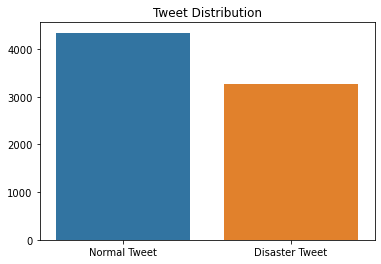

In [7]:
sns.barplot(x=['Normal Tweet', 'Disaster Tweet'],
           y=df['target'].value_counts().values)
plt.title('Tweet Distribution')

# Model

In [8]:
from fastai2.text.all import *
#from nbdev.showdoc import *

In [9]:
path = Path()
path.ls()

(#4) [Path('train.csv'),Path('tweet_disaster prediction model.ipynb'),Path('.ipynb_checkpoints'),Path('models')]

In [10]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [11]:
df.shape

(7613, 5)

Let's shuffle the data and set 20% of the data for model validation

In [12]:
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
len(df) *0.8

6090.400000000001

In [14]:
df['is_valid'] = False

In [15]:
df.loc[:int(len(df)*0.8),'is_valid'] = True

In [16]:
df['is_valid'].value_counts()

True     6091
False    1522
Name: is_valid, dtype: int64

In [17]:
df['text'][5000]

'I guess ill never be able to go to mayhem...'

In [18]:
dbunch_lm = TextDataLoaders.from_df(df, text_col='text', 
                                    label_col='target', 
                                    path=path, is_lm=True,
                                    valid_col='is_valid')

In [19]:
dbunch_lm.train_ds[0]

(TensorText([   2,    7,  139,   10,    0,   10,   20,  357,   16, 1149,   97,   12,
           10,    9,    9,   11,    9,    0,    8, 2757,   10,    7,  292,    7,
         1472,    7, 1615,    7, 1313,   55, 2861,    7,  537,    7, 3465, 1726,
           35,   35,    7,   82,   27,   54,    8,    0,   44]),)

In [20]:
dbunch_lm.vocab[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 '/',
 ':',
 't.co',
 'http',
 '#',
 'the',
 '.',
 'a',
 'in',
 'to',
 'of']

In [21]:
dbunch_lm.show_batch()

,text,text_
0,xxbos xxunk + do anything to fix that . xxmaj of the few people he had every xxunk in his life xxmaj charles was one of the casualties . xxbos xxunk sir i just only wanted to make a point about xxunk you made and said he is lying about bridge collapse . xxbos xxmaj bomb head ? xxmaj xxunk decisions dat produced more dead children than dead bodies trapped xxunk buildings,xxunk + do anything to fix that . xxmaj of the few people he had every xxunk in his life xxmaj charles was one of the casualties . xxbos xxunk sir i just only wanted to make a point about xxunk you made and said he is lying about bridge collapse . xxbos xxmaj bomb head ? xxmaj xxunk decisions dat produced more dead children than dead bodies trapped xxunk buildings on
1,/ t.co / xxunk m # newsintweets http : / / t.co / xxunk xxbos xxunk dad why do nt you claim me that mean that not right we look the same same eyes same blood same xbox 360 xxup smh xxunk xxbos a xxmaj xxunk of xxmaj two xxmaj xxunk - xxmaj body xxmaj horrors http : / / t.co / xxunk # virus # xxunk # bioterrorism xxbos ' if,t.co / xxunk m # newsintweets http : / / t.co / xxunk xxbos xxunk dad why do nt you claim me that mean that not right we look the same same eyes same blood same xbox 360 xxup smh xxunk xxbos a xxmaj xxunk of xxmaj two xxmaj xxunk - xxmaj body xxmaj horrors http : / / t.co / xxunk # virus # xxunk # bioterrorism xxbos ' if you
2,xxunk xxmaj full ( audio ) xxbos xxunk xxmaj mercury xxmaj cyclone xxup gt xxmaj xxunk xxmaj xxunk xxmaj very xxup nice xxup xxunk xxmaj cobra xxmaj jet xxunk xxup gt http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj there are no four xxunk - of pain of desire that is the origin of pain of the obliteration of that desire of the pain,xxmaj full ( audio ) xxbos xxunk xxmaj mercury xxmaj cyclone xxup gt xxmaj xxunk xxmaj xxunk xxmaj very xxup nice xxup xxunk xxmaj cobra xxmaj jet xxunk xxup gt http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj there are no four xxunk - of pain of desire that is the origin of pain of the obliteration of that desire of the pain to
3,: / / t.co / xxunk \n▁ # drones # xxunk http : / / t.co / xxunk xxbos xxunk xxunk xxunk xxmaj so … where are the xxunk xxunk and burning buildings xxrep 4 ? xxup white xxup lives xxup matter xxrep 6 ! xxbos xxmaj xxunk xxmaj night and xxmaj xxunk xxmaj xxunk xxrep 3 x enjoy a wild teen xxunk http : / / t.co / qew4c5m1xd xxmaj view,/ / t.co / xxunk \n▁ # drones # xxunk http : / / t.co / xxunk xxbos xxunk xxunk xxunk xxmaj so … where are the xxunk xxunk and burning buildings xxrep 4 ? xxup white xxup lives xxup matter xxrep 6 ! xxbos xxmaj xxunk xxmaj night and xxmaj xxunk xxmaj xxunk xxrep 3 x enjoy a wild teen xxunk http : / / t.co / qew4c5m1xd xxmaj view and
4,# xxmaj manchester on xxmaj rt xxunk xxup nb before xxmaj xxunk xxmaj rd stop and go traffic back to xxup xxunk delay of 4 mins # traffic xxbos xxmaj sinkhole xxunk xxunk opens in housing estate \n xxmaj irish xxmaj xxunk xxmaj aug 2015 xxbos # xxmaj bestnaijamade : 16yr old xxup pkk suicide bomber who detonated bomb in … http : / / t.co / ksawlyux02 xxwrep 3 bestnaijamade beû,xxmaj manchester on xxmaj rt xxunk xxup nb before xxmaj xxunk xxmaj rd stop and go traffic back to xxup xxunk delay of 4 mins # traffic xxbos xxmaj sinkhole xxunk xxunk opens in housing estate \n xxmaj irish xxmaj xxunk xxmaj aug 2015 xxbos # xxmaj bestnaijamade : 16yr old xxup pkk suicide bomber who detonated bomb in … http : / / t.co / ksawlyux02 xxwrep 3 bestnaijamade beû _
5,xxmaj i 'm xxunk the evacuation cost you the front ? xxbos xxmaj cute & & all xxunk ' the life then you xxunk in on one 's face and you have a meme ready : ' i 've seen the xxmaj gates of xxmaj hell and survived ' xxbos xxmaj xxunk back up xxbos xxmaj yo i got bars and xxmaj i 'm not even a xxunk xxbos xxmaj the bomb,i 'm xxunk the evacuation cost you the front ? xxbos xxmaj cute & & all xxunk ' the life then you xxunk in on one 's face and you have a meme rea

# Language model

In [22]:
bs = 32

In [23]:
path.ls()

(#4) [Path('train.csv'),Path('tweet_disaster prediction model.ipynb'),Path('.ipynb_checkpoints'),Path('models')]

In [24]:
len(dbunch_lm.vocab)

4568

In [25]:
learn = language_model_learner(dbunch_lm, AWD_LSTM, drop_mult=0.3, 
                               metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.25118863582611084)

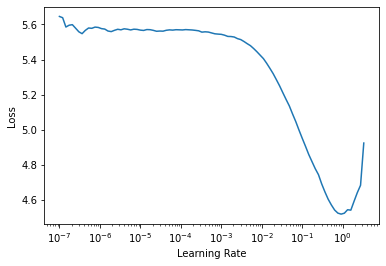

In [26]:
learn.lr_find()

In [27]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.255739,4.763798,0.301351,117.190140,00:10


In [28]:
learn.save('fit_head')

In [29]:
learn.load('fit_head');

In [30]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(10, 2e-2, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.318294,3.830227,0.375350,46.073002,00:10
1,4.022458,4.364818,0.292686,78.635094,00:09
2,3.673906,3.652724,0.398133,38.579617,00:09
3,3.219373,3.670342,0.419862,39.265324,00:09
4,2.773297,3.853000,0.422268,47.134274,00:09
5,2.404130,4.008598,0.417831,55.069626,00:09
6,2.069800,4.024385,0.420515,55.945915,00:09
7,1.802565,4.064525,0.424019,58.237221,00:09
8,1.605108,4.040521,0.419537,56.855938,00:09
9,1.428457,4.034862,0.420226,56.535095,00:10


In [32]:
learn.save('fine_tuned')

In [33]:
learn.load('fine_tuned');

In [34]:
TEXT = 'Car accidents'
N_WORDS = 30
N_SENTENCES = 2

In [35]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Car accidents have drawn no - injuries But I 'm happy you 've survived all of them . Hope you 're okay !!! Do n't
Car accidents have a no - go - go away from the British Bake Back in Kenya http : / / t.co / @worldnetdaily #


In [36]:
learn.save_encoder('fine_tuned_enc')

# Classifier

In [37]:
tweet_class = DataBlock(blocks=(TextBlock.from_df('text',vocab=dbunch_lm.vocab),CategoryBlock),
                       get_y = ColReader('target'),
                       get_x = ColReader('text'),
                       splitter=ColSplitter())

In [38]:
df.head(2)

,id,keyword,location,text,target,is_valid
0,6102,hellfire,NaN,@JYHeffect my good you stay in NY??? ?,0,True
1,8829,sirens,NaN,@iK4LEN Sirens was cancelled.,0,True


In [39]:
pd.crosstab(df['is_valid'],df['target'])

target,0,1
is_valid,,
False,851,671
True,3491,2600


In [40]:
dbunch_class = tweet_class.dataloaders(df,path, bs=bs, seq_len=80)

In [41]:
dbunch_class.show_batch()

,text,category
0,xxbos xxup info xxup u. xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 . xxup wnd : xxunk / 6 .,0
1,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0
2,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0
3,xxbos xxunk xxup thank xxup you xxup for xxup understanding xxup the xxup gov . xxup only xxup tells xxup us xxup about 5 % xxup of xxup what s xxup really xxup going xxup on i xxup have xxup military xxup house & & xxup cia xxup xxunk xxrep 3 !,0
4,xxbos xxmaj xxunk xxmaj hot xxmaj deals # xxunk > > http : / / t.co / xxunk xxunk xxunk xxunk xxunk xxup led xxmaj work xxmaj light xxup flood xxmaj lamp xxmaj xxunk xxmaj truck xxup suv xxup xxunk xxup aû _ http : / / t.co / xxunk,0
5,xxbos # nowplaying * xxmaj cliff xxmaj richard - i xxmaj could xxmaj easily xxmaj fall ( in xxmaj love xxmaj with xxmaj you ) ( & & xxmaj xxunk ) * # xxmaj internet # xxmaj xxunk # xxmaj radio xxmaj on http : / / t.co / xxunk,0
6,xxbos xxup i 'm xxup laughing xxup in xxup the xxup face xxup of xxup casualties xxup and xxup xxunk xxup the xxup first xxup time xxup i 'm xxup thinking xxup past xxup tomorrow xxup but i xxup am xxup not xxup xxunk xxup away xxup my xxup shot,1
7,xxbos xxmaj haha xxmaj south xxmaj tampa is getting flooded xxunk xxup wait a xxup second i xxup live xxup in xxup south xxup tampa xxup what xxup am i xxup gon na xxup do xxup what xxup am i xxup gon na xxup do xxup xxunk # flooding,1
8,xxbos xxmaj conditions for xxmaj paris xxup fr at xxunk am xxup xxunk : xxmaj current xxmaj conditions : \n xxmaj fair xxunk xxunk : \n xxmaj xxunk - xxmaj xxunk . xxmaj high : xxunk xxmaj low : xxunk \n xxmaj xxunk - xxup pm xxmaj thunderstorm …,0


In [42]:
learn = text_classifier_learner(dbunch_class, AWD_LSTM,
                                drop_mult=0.3, metrics=accuracy).to_fp16()
learn.load_encoder('fine_tuned_enc')

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.004365158267319202)

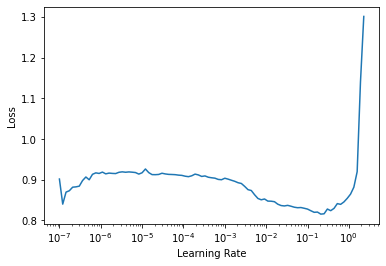

In [43]:
learn.lr_find()

In [44]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.765621,0.529380,0.748481,00:09


In [45]:
learn.save('first')
learn.load('first')

In [46]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.658757,0.565911,0.727959,00:10
1,0.541278,0.629307,0.746183,00:08
2,0.452028,0.625421,0.756690,00:05
3,0.381687,0.638110,0.734198,00:05
4,0.312132,0.645469,0.738302,00:05


In [47]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3),moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.229639,0.703110,0.737810,00:05


In [48]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.225316,0.719005,0.736332,00:06
1,0.195596,0.736392,0.741586,00:06


In [49]:
learn.fit_one_cycle(4,slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.196479,0.749885,0.741586,00:06
1,0.171783,0.801530,0.732556,00:06
2,0.153960,0.826557,0.740437,00:06
3,0.147267,0.789741,0.740273,00:10


In [50]:
learn.predict("there's a fire emergency in my city")

('1', tensor(1), tensor([2.0377e-07, 1.0000e+00]))

In [51]:
learn.predict("What a peaceful place to live")

('1', tensor(1), tensor([0.0318, 0.9682]))

In [52]:
learn.show_results()

,text,category,category_
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0,0
1,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0,0
2,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,0
3,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,0
4,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,0
5,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,0,0
6,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxup xxunk xxmaj please # xxup rt,0,0
7,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0,0
8,xxbos xxmaj morgan xxmaj silver xxmaj dollar xxunk s xxmaj gem xxup bu xxup xxunk xxmaj xxunk xxmaj xxunk xxmaj blazing xxup ms xxrep 5 + xxmaj high grade ! - xxmaj full read û _ http : / / t.co / xxunk http : / / t.co / xxunk,0,0


# Interpretation

In [53]:
from fastai.text.interpret import *

In [54]:
interp = ClassificationInterpretation.from_learner(learn)

In [55]:
interp.confusion_matrix()

array([[2783,  708],
       [ 874, 1726]])

In [56]:
interp.plot_top_losses(5)

,input,target,predicted,probability,loss
0,xxbos xxmaj hellfire is surrounded by desires so be careful and donûªt let your desires control you ! # xxmaj afterlife,1,0,0.9999980926513672,13.148439407348633
1,xxbos xxmaj hellfire ! xxmaj we donûªt even want to think about it or mention it so letûªs not do anything that leads to it # islam !,1,0,0.9999979734420776,13.109376907348633
2,xxbos xxmaj large rain xxunk falling in xxmaj rock xxmaj hill off xxmaj xxunk xxmaj road . # rain # xxunk # drought,0,1,0.9999972581863403,12.82422161102295
3,xxbos xxmaj xxunk police investigating pedestrian fatality hit by a train xxmaj thursday http : / / t.co / xxunk,0,1,0.9999963045120239,12.523441314697266
4,xxbos xxmaj even if u have your weapon and your xxunk we gon na put them xxunk on your ass xxrep 4 ?,1,0,0.9999911785125732,11.640633583068848


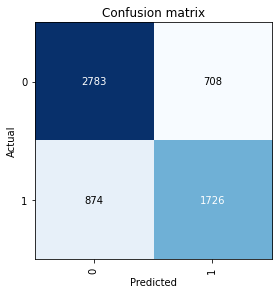

In [57]:
interp.plot_confusion_matrix()